# Import Maf Files

This script imports somatic mutations from a local maf file from tcga and creates a data frame with the relevant information. It also explores the somatic mutation data by creating some intersting graphs.

Import necessary modules

In [5]:
%pylab inline
import pandas as pd
import numpy as np
import os
import sklearn as sk
from sklearn.cluster import AffinityPropagation
from sklearn import datasets
from sklearn import metrics
from multiprocessing import Pool
import pickle

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Somatic Mutations from TCGA

Read maf files. Originally downloaded from tcga website. No special access was necessary.

In [6]:
data_dir = '../raw_data/maf_files_thyroid/'
maf_files = os.listdir(data_dir)
maf = {}
for f in maf_files:
    input_file = open(data_dir+f, 'r')
    maf[f] = pd.read_csv(input_file, sep='\t', header=0, index_col=0, low_memory=True)

In [7]:
m = pd.concat(maf)
m = m.dropna(axis=1, how='all')
print m.columns
cols = ['Ncbi_Build', 'Chrom', 'Start_Position', 
         'End_Position', 'Strand', 'Reference_Allele', 
         'Tumor_Seq_Allele1', 'Tumor_Seq_Allele2',
         'Tumor_Sample_Barcode', 'Entrez_Gene_Id',
         'Variant_Classification','Variant_Type']
m = m[cols]
m = m.reset_index()
m = m[m.Entrez_Gene_Id != 0]

Index([u'Entrez_Gene_Id', u'Center', u'Ncbi_Build', u'Chrom', u'Start_Position', u'End_Position', u'Strand', u'Variant_Classification', u'Variant_Type', u'Reference_Allele', u'Tumor_Seq_Allele1', u'Tumor_Seq_Allele2', u'Dbsnp_Rs', u'Dbsnp_Val_Status', u'Tumor_Sample_Barcode', u'Matched_Norm_Sample_Barcode', u'Match_Norm_Seq_Allele1', u'Match_Norm_Seq_Allele2', u'Tumor_Validation_Allele1', u'Tumor_Validation_Allele2', u'Match_Norm_Validation_Allele1', u'Match_Norm_Validation_Allele2', u'Verification_Status', u'Validation_Status', u'Mutation_Status', u'Sequencing_Phase', u'Sequence_Source', u'Validation_Method', u'Score', u'Bam_File', u'Sequencer', u'Tumor_Sample_UUID', u'Matched_Norm_Sample_UUID', u'File_Name', u'Archive_Name', u'Line_Number'], dtype='object')


In [8]:
m.head()

,level_0,Hugo_Symbol,Ncbi_Build,Chrom,Start_Position,End_Position,Strand,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Tumor_Sample_Barcode,Entrez_Gene_Id,Variant_Classification,Variant_Type
0,bcgsc.ca__IlluminaHiSeq_automated_DNA_sequenci...,A1CF,hg19,10,52576034,52576034,+,C,A,A,TCGA-ET-A39P-01A-21D-A19J-08,29974,Silent,SNP
1,bcgsc.ca__IlluminaHiSeq_automated_DNA_sequenci...,A2M,hg19,12,9264798,9264798,+,C,T,T,TCGA-BJ-A0ZB-01A-11D-A10S-08,2,Missense_Mutation,SNP
2,bcgsc.ca__IlluminaHiSeq_automated_DNA_sequenci...,A2ML1,hg19,12,8990110,8990111,+,GA,-,-,TCGA-ET-A40S-01A-11D-A23M-08,144568,Frame_Shift_Del,DEL
3,bcgsc.ca__IlluminaHiSeq_automated_DNA_sequenci...,A2ML1,hg19,12,8995756,8995756,+,A,G,G,TCGA-E8-A413-01A-21D-A23M-08,144568,Silent,SNP
4,bcgsc.ca__IlluminaHiSeq_automated_DNA_sequenci...,A2ML1,hg19,12,9009820,9009820,+,G,A,A,TCGA-DJ-A4UT-01A-11D-A257-08,144568,Missense_Mutation,SNP


Organize pandas data frame.

#### Adding useful columns

Boolean for both alleles being mutated

In [9]:
def check_bi_allelic(x):
    if x[0] == x[1]:
        return True
    else:
        return False
m["Both_Alleles"] = m[['Tumor_Seq_Allele1', 'Tumor_Seq_Allele2']].apply(check_bi_allelic, axis=1)

Constructing 10 digit patieng barcode

In [10]:
m['Patient_Barcode'] = m.Tumor_Sample_Barcode.str[:12]

In [29]:
len(m.Patient_Barcode.unique())

441

Creating a numerical identifier for patients; will be helpful for visualizations.

In [11]:
unique_patient_identifiers = list(m.Patient_Barcode.unique())
all_patient_rows = list(m.Patient_Barcode)
all_unique_identifiers = []
for p_id in all_patient_rows:
    all_unique_identifiers.append(unique_patient_identifiers.index(p_id))
m['Patient_Number'] = pd.Series(all_unique_identifiers)

Creating a numerical identifier for genes; will be helpful for visualizations also.

In [12]:
unique_gene_identifier = list(m.Entrez_Gene_Id.unique())
all_entrez = list(m.Entrez_Gene_Id)
Seq_Gene_Id = []
for gene in all_entrez:
    Seq_Gene_Id.append(unique_gene_identifier.index(gene))
m['Seq_Gene_Id'] = pd.Series(Seq_Gene_Id)

Reducing data frame to relevant rows.

In [13]:
mr = m[['Hugo_Symbol', 'Entrez_Gene_Id', 'Patient_Barcode', 'Variant_Classification', 'Both_Alleles', 'Start_Position']]

In [14]:
mr.head()

,Hugo_Symbol,Entrez_Gene_Id,Patient_Barcode,Variant_Classification,Both_Alleles,Start_Position
0,A1CF,29974,TCGA-ET-A39P,Silent,True,52576034
1,A2M,2,TCGA-BJ-A0ZB,Missense_Mutation,True,9264798
2,A2ML1,144568,TCGA-ET-A40S,Frame_Shift_Del,True,8990110
3,A2ML1,144568,TCGA-E8-A413,Silent,True,8995756
4,A2ML1,144568,TCGA-DJ-A4UT,Missense_Mutation,True,9009820


In [15]:
mr = mr.drop_duplicates()

In [16]:
mr.count()

Hugo_Symbol               27116
Entrez_Gene_Id            27116
Patient_Barcode           27116
Variant_Classification    27116
Both_Alleles              27116
Start_Position            27116
dtype: int64

In [17]:
mr[(mr['Start_Position'] == 140453136) & (mr['Patient_Barcode'] == 'TCGA-DJ-A2PU')]

,Hugo_Symbol,Entrez_Gene_Id,Patient_Barcode,Variant_Classification,Both_Alleles,Start_Position
1972,BRAF,673,TCGA-DJ-A2PU,Missense_Mutation,True,140453136
20498,BRAF,673,TCGA-DJ-A2PU,Missense_Mutation,False,140453136


In [18]:
mr.to_csv('../data_frames/mr.csv')

In [19]:
mr = pd.read_csv('../data_frames/mr.csv', index_col=0)

#### Getting a feel for the data

How many patients are we working with?

In [20]:
len(m.Patient_Barcode.unique())

441

How many mutations do each of the patients have?

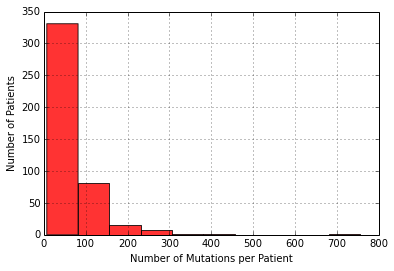

In [35]:
ax = m.Patient_Barcode.value_counts().hist(color='r', alpha=0.8)
ax.set_xlabel("Number of Mutations per Patient")
ax.set_ylabel("Number of Patients")

What kinds of mutations are we dealing with?

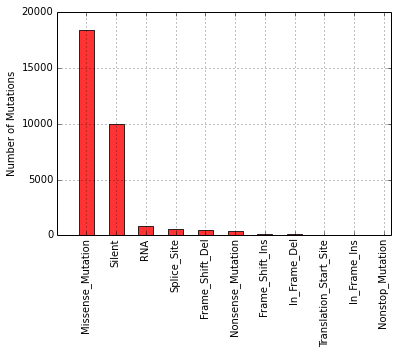

In [37]:
ax = m.Variant_Classification.value_counts().plot(kind='bar', color='r', alpha=0.8)
ax.set_ylabel("Number of Mutations")

How are the mutations distributed among the patients?

(0, 441)

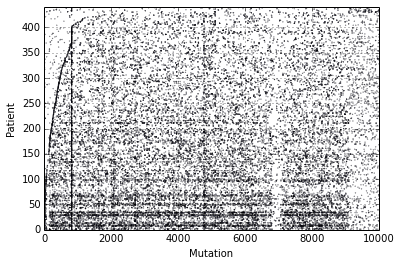

In [59]:
ax = m.plot(kind='scatter', y='Patient_Number', x='Seq_Gene_Id', s=0.05)
ax.set_ylabel("Patient")
ax.set_xlabel("Mutation")
ax.set_xlim(0,10000)
ax.set_ylim(0,441)

Let's look a little more concretely. How many mutations do we see per gene?

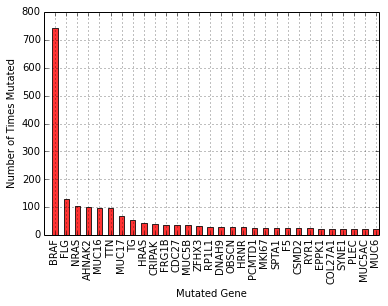

In [38]:
ax = m['Hugo_Symbol'].value_counts()[:30].plot(kind='bar', color='r', alpha=0.8)
ax.set_xlabel("Mutated Gene")
ax.set_ylabel("Number of Times Mutated")

Interesting. It looks like BRAF is mutated a TON while all of the other mutations have low frequency and are spread throughout many genes. What percentage of patients have a mutation in BRAF? Do some patients have multiple while others have none? Or are they evenly distributed? Do some only have BRAF?

Percentage of patients with BRAF mutation:  0.596371882086
Percentage of BRAF mutations that are bi-allelic:  0.342780026991
Average number of mutations in patients with BRAF:  73.1064638783
Average number of mutations in pations without BRAF:  70.1814058957


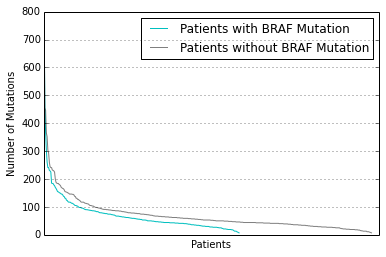

In [56]:
braf_mutations = m[m['Hugo_Symbol'] == 'BRAF']
num_patients_with_BRAF = len(braf_mutations.Patient_Barcode.unique())
num_patients = len(m.Patient_Barcode.unique())
print "Percentage of patients with BRAF mutation: ", float(num_patients_with_BRAF)/num_patients
num_BRAF_mutations = len(braf_mutations)
num_BRAF_mutations_biallelic = len(braf_mutations[braf_mutations['Both_Alleles'] == True])
print "Percentage of BRAF mutations that are bi-allelic: ", float(num_BRAF_mutations_biallelic)/num_BRAF_mutations
# create df that only includes patients with braf
patients_with_BRAF = braf_mutations.Patient_Barcode.unique()
df_patients_with_BRAF = m[m['Patient_Barcode'].isin(patients_with_BRAF)]
avg_num_mutations_per_patient_BRAF = np.mean(df_patients_with_BRAF.Patient_Barcode.value_counts())
avg_num_mutations_per_patient = np.mean(m.Patient_Barcode.value_counts())
ax = df_patients_with_BRAF.Patient_Barcode.value_counts().plot(color='c', label="Patients with BRAF Mutation", xticks=None)
ax.set_xlabel("Patients")
ax.set_ylabel("Number of Mutations")
m.Patient_Barcode.value_counts().plot(color='k', alpha=0.5, label="Patients without BRAF Mutation", ax=ax)
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels)
ax.get_xaxis().set_ticks([])
ax.set_xlabel("Patients")
print "Average number of mutations in patients with BRAF: ", avg_num_mutations_per_patient_BRAF
print "Average number of mutations in pations without BRAF: ", avg_num_mutations_per_patient